In [1]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import xgboost as xgb
import numpy as np

In [2]:
datasig=pd.read_csv("sig_had_values.csv")
databkg=pd.read_csv("bkg_had_values.csv")
databkg["label"]=0
datasig["label"]=1

data2=datasig.append(databkg,ignore_index=True)

In [3]:
data2.shape
data2.head()

,JetPt1,JetEta1,JetPhi1,JetMass1,JetBTagger1,JetPt2,JetEta2,JetPhi2,JetMass2,JetBTagger2,...,JetEta4,JetPhi4,JetMass4,JetBTagger4,ZZPt,ZZPhi,ZZEta,ZZMass,weight,label
0,167.150,-0.776438,1.440750,25.8188,0.179759,70.7794,-0.154553,0.350386,14.0573,0.975653,...,-0.483385,2.91395,3.70648,0.010560,219.4010,-1.789890,-1.116720,126.792,0.000056,1
1,133.301,-0.884264,-0.267022,19.3262,0.014708,113.6030,-0.802912,-1.724960,19.7239,0.973898,...,-1.717180,2.89912,10.40980,0.033225,249.7370,0.916814,-0.739110,127.321,0.000072,1
2,173.966,-0.646671,-2.781010,17.7597,0.213439,113.9620,-0.347223,1.699790,21.0720,0.446442,...,-0.093808,-2.43640,10.95780,0.023086,217.2710,-0.333024,0.374378,123.908,0.000042,1
3,123.883,0.599243,-1.795990,15.0571,0.992366,119.9060,-0.912783,1.646610,23.6522,0.079898,...,-0.907467,1.07840,9.10459,0.237895,11.0847,0.406864,2.851050,135.255,0.000047,1
4,131.413,-1.466730,-2.230160,17.1440,0.974358,82.7551,-1.334420,2.084190,10.2249,0.088999,...,-0.760526,0.73594,9.12132,0.029613,94.3562,1.316190,-1.236170,124.261,0.000022,1


In [4]:
X,Y=data2.iloc[:,:-2],data2.iloc[:,-1]
weights=data2.iloc[:,-2]
X_train, X_test, y_train, y_test,weight_train,weight_test= train_test_split(X, Y,weights,test_size=0.3, random_state=7)

In [5]:
weight_train=weight_train*10**2
weight_test=weight_test*10**2
weight_train=np.asarray(weight_train)
weight_test=np.asarray(weight_test)
y_test=np.asarray(y_test)
y_train=np.asarray(y_train)
X_test=np.asarray(X_test)
X_train=np.asarray(X_train)


In [6]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train,sample_weight=weight_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.91%


In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

AUC: 0.684


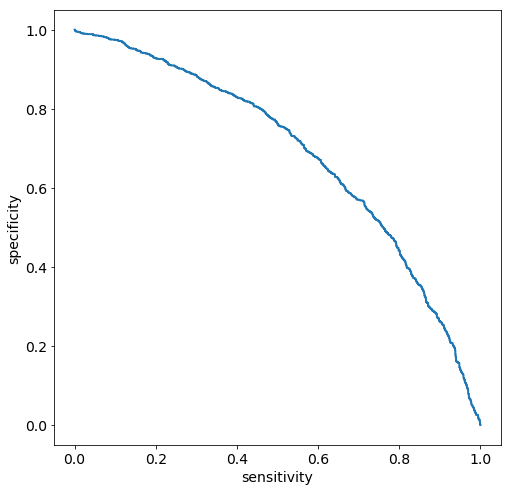

In [8]:
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs,sample_weight=weight_test)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs,sample_weight=weight_test)
# plot the roc curve for the model
plt.figure(figsize=(8,8))
plt.plot(tpr, 1-fpr,linewidth=2)
# show the plot
plt.xlabel("sensitivity",fontsize=14)
plt.ylabel("specificity",fontsize=14)
plt.tick_params(axis="both",labelsize=14)
plt.show()

In [9]:
for kk in range(tpr.size):
    if(round(tpr[kk],3)==0.400):
        speci=1-fpr[kk]
        print(speci)

0.829733887367416
0.8288582246176575


In [10]:
filename="xgboost_had.CSV"
with open(filename,"w") as file:
    for kk in range(tpr.size):
        file.write(str(fpr[kk]))
        file.write(" ")
        file.write(str(tpr[kk]))
        file.write("\n")

In [11]:
fpr.size

2980

In [12]:
tpr.size

2980

In [13]:
sig_probs=[]
bkg_probs=[]
sig_weight=[]
bkg_weight=[]
for index in range(y_test.shape[0]):
    if(y_test[index]==1.0):
        sig_probs.append(probs[index])
        sig_weight.append(weight_test[index])
    else:
        bkg_probs.append(probs[index])
        bkg_weight.append(weight_test[index])

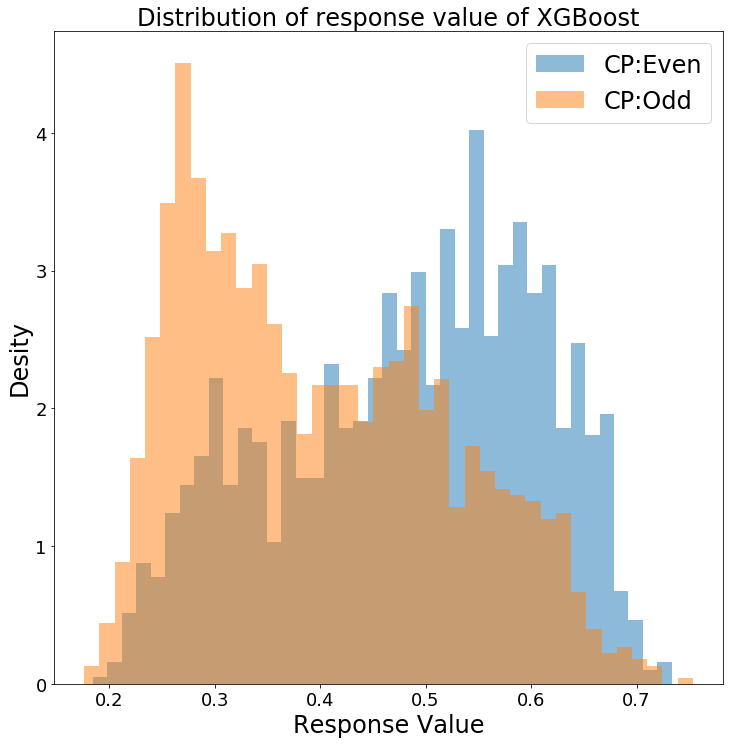

In [17]:
plt.figure(3)
plt.rcParams['figure.figsize'] = [12, 12]

plt.hist(sig_probs,bins=40,density=True,alpha=0.5,label="CP:Even");
plt.hist(bkg_probs,bins=40,density=True,alpha=0.5,label="CP:Odd");
plt.legend(loc='upper right',fontsize=24)
plt.title("Distribution of response value of XGBoost",fontsize=24)
plt.xlabel("Response Value",fontsize=24)
plt.ylabel("Desity",fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('xgboost_had_output.png')
plt.show()

In [15]:
thresholds

array([1.7534306 , 0.75343066, 0.7335599 , ..., 0.17911676, 0.17777346,
       0.17615716], dtype=float32)

In [16]:
from ROOT import TFile, TH1F
file=TFile("xgboost_had_hist.root","RECREATE")
h1=TH1F("sig","histo of signal",40,0,1)
h2=TH1F("bkg","histo of background",40,0,1)
for kk in range(len(sig_probs)):
    h1.Fill(sig_probs[kk],sig_weight[kk])
for kk in range(len(bkg_probs)):
    h2.Fill(bkg_probs[kk],bkg_weight[kk])
inte1=h2.Integral("width")
scale1=1/h1.Integral("width")
scale2=1/h2.Integral("width")
h1.Scale(scale1)
h2.Scale(scale2)
file.Write();

Welcome to JupyROOT 6.19/01
